In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
from plotly.subplots import make_subplots
import xgboost as xgb
from tqdm.auto import tqdm
from sklearn.utils import shuffle
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, label_binarize, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score, f1_score, r2_score, mean_squared_error,
    accuracy_score, log_loss, confusion_matrix, classification_report,
    mean_absolute_error, explained_variance_score
)
from sklearn.linear_model import (
    LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet,
    BayesianRidge, PassiveAggressiveRegressor
)
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import (
    RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier,
    RandomForestRegressor, GradientBoostingRegressor
)
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.cluster import KMeans
from sklearn.preprocessing import OrdinalEncoder
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [86]:
#Load the datafile and print out first few rows in the dataset
df = pd.read_csv('../input/steel-industry-energy-consumption/Steel_industry_data.csv')
df.head() 

date  Usage_kWh  Lagging_Current_Reactive.Power_kVarh  \
0  01/01/2018 00:15       3.17                                  2.95   
1  01/01/2018 00:30       4.00                                  4.46   
2  01/01/2018 00:45       3.24                                  3.28   
3  01/01/2018 01:00       3.31                                  3.56   
4  01/01/2018 01:15       3.82                                  4.50   

   Leading_Current_Reactive_Power_kVarh  CO2(tCO2)  \
0                                   0.0        0.0   
1                                   0.0        0.0   
2                                   0.0        0.0   
3                                   0.0        0.0   
4                                   0.0        0.0   

   Lagging_Current_Power_Factor  Leading_Current_Power_Factor   NSM  \
0                         73.21                         100.0   900   
1                         66.77                         100.0  1800   
2                         70.28                         100.0  2700   
3                         68.09                         100.0  3600   
4                         64.72                         100.0  4500   

  WeekStatus Day_of_week   Load_Type  
0    Weekday      Monday  Light_Load  
1    Weekday      Monday  Light_Load  
2    Weekday      Monday  Light_Load  
3    Weekday      Monday  Light_Load  
4    Weekday      Monday  Light_Load

# Data Cleaning

In [88]:
#Drop the index column
df.reset_index(drop=True, inplace=True) 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38544 entries, 0 to 38543
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  38544 non-null  object 
 1   Usage_kWh                             38436 non-null  float64
 2   Lagging_Current_Reactive.Power_kVarh  38544 non-null  float64
 3   Leading_Current_Reactive_Power_kVarh  38544 non-null  float64
 4   CO2(tCO2)                             38544 non-null  float64
 5   Lagging_Current_Power_Factor          38435 non-null  float64
 6   Leading_Current_Power_Factor          38544 non-null  float64
 7   NSM                                   38544 non-null  int64  
 8   WeekStatus                            38544 non-null  object 
 9   Day_of_week                           38544 non-null  object 
 10  Load_Type                             38544 non-null  object 
dtypes: float64(6), 

In [89]:
df.shape

(38544, 11)

In [90]:
# Check for duplicated rows
duplicate_rows = df[df.duplicated()]

# Print the duplicated rows
print("Duplicated Rows:")
print(duplicate_rows)

Duplicated Rows:
                   date  Usage_kWh  Lagging_Current_Reactive.Power_kVarh  \
35040  29/04/2018 07:15       2.88                                  3.82   
35041  04/10/2018 12:00      60.77                                 48.02   
35042  26/01/2018 11:30     120.42                                 59.65   
35043  02/06/2018 14:30       3.13                                  0.00   
35044  07/12/2018 15:00      58.86                                 20.99   
...                 ...        ...                                   ...   
38539  22/11/2018 04:00       3.20                                  3.10   
38540  03/01/2018 06:30       4.57                                  4.36   
38541  22/09/2018 08:45       3.31                                  3.17   
38542  11/04/2018 19:15      77.87                                 21.82   
38543  16/02/2018 01:30       3.10                                  3.28   

       Leading_Current_Reactive_Power_kVarh  CO2(tCO2)  \
35040       

In [91]:
# Removing Duplicates:
df.drop_duplicates(inplace=True)

In [92]:
# Handling Missing Values:
#Check if there is missing value 
df.isnull().sum().sort_values(ascending=False)

Usage_kWh                               101
Lagging_Current_Power_Factor            101
date                                      0
Lagging_Current_Reactive.Power_kVarh      0
Leading_Current_Reactive_Power_kVarh      0
CO2(tCO2)                                 0
Leading_Current_Power_Factor              0
NSM                                       0
WeekStatus                                0
Day_of_week                               0
Load_Type                                 0
dtype: int64

In [93]:
# Drop rows with missing values
df.dropna(inplace=True)

In [94]:
# check nulls after cleaning  
df.isnull().sum().sort_values(ascending=False)

date                                    0
Usage_kWh                               0
Lagging_Current_Reactive.Power_kVarh    0
Leading_Current_Reactive_Power_kVarh    0
CO2(tCO2)                               0
Lagging_Current_Power_Factor            0
Leading_Current_Power_Factor            0
NSM                                     0
WeekStatus                              0
Day_of_week                             0
Load_Type                               0
dtype: int64

In [95]:
df.shape

(34838, 11)

In [96]:
#Summary statistics of the datase
df.describe()

Usage_kWh  Lagging_Current_Reactive.Power_kVarh  \
count  34838.000000                          34838.000000   
mean      41.633162                             13.059339   
std      385.409022                             16.303616   
min        0.000000                              0.000000   
25%        3.200000                              2.300000   
50%        4.570000                              5.000000   
75%       51.520000                             22.750000   
max    14429.000000                             96.910000   

       Leading_Current_Reactive_Power_kVarh     CO2(tCO2)  \
count                          34838.000000  34838.000000   
mean                               3.855393      0.011591   
std                                7.406350      0.016174   
min                                0.000000      0.000000   
25%                                0.000000      0.000000   
50%                                0.000000      0.000000   
75%                                2.020000      0.020000   
max                               27.760000      0.070000   

       Lagging_Current_Power_Factor  Leading_Current_Power_Factor  \
count                  34838.000000                  34838.000000   
mean                      80.556606                     84.421058   
std                       18.939339                     30.410777   
min                        0.000000                      0.000000   
25%                       63.200000                     99.700000   
50%                       87.955000                    100.000000   
75%                       98.990000                    100.000000   
max                      100.000000                    100.000000   

                NSM  
count  34838.000000  
mean   42758.396004  
std    24938.883253  
min        0.000000  
25%    21600.000000  
50%    43200.000000  
75%    64800.000000  
max    85500.000000

In [97]:
df = df.drop(['Leading_Current_Power_Factor'], axis=1)

In [98]:
numeric_cols=[]
for col in df.columns:
    if np.issubdtype(df[col].dtype, np.number):
        numeric_cols.append(col)

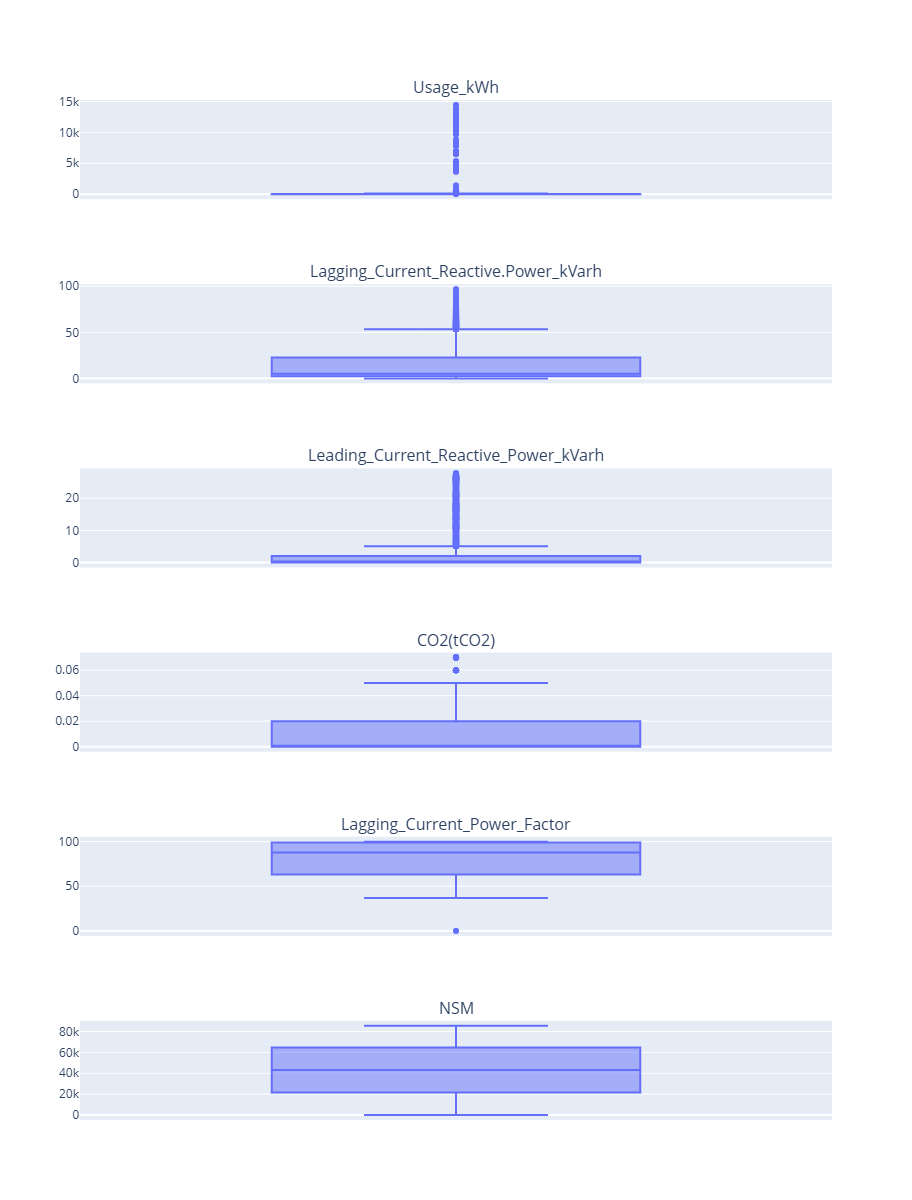

In [99]:
#Detect the outliers 
fig = make_subplots(rows=len(numeric_cols), cols=1, subplot_titles=numeric_cols)

for i, feature in enumerate(numeric_cols):
    boxplot = px.box(df, y=feature, title=f'Boxplot of {feature}')
    # Add boxplot to subplots
    for data in boxplot.data:
        fig.add_trace(data, row=i+1, col=1)

fig.update_layout(height=200*len(numeric_cols), showlegend=False)

fig.show() 

In [100]:
def remove_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

In [101]:
def remove_outliers_zscore(df, col):
    mean = df[col].mean()
    std = df[col].std()
    z_scores = (df[col] - mean) / std
    return df[(z_scores > -3) & (z_scores < 3)]

In [102]:
for col in numeric_cols:
    if df[col].skew() > 1 or df[col].skew() < -1:
        df = remove_outliers_iqr(df, col)
    else:
        df = remove_outliers_zscore(df, col)

df.shape

(26323, 10)

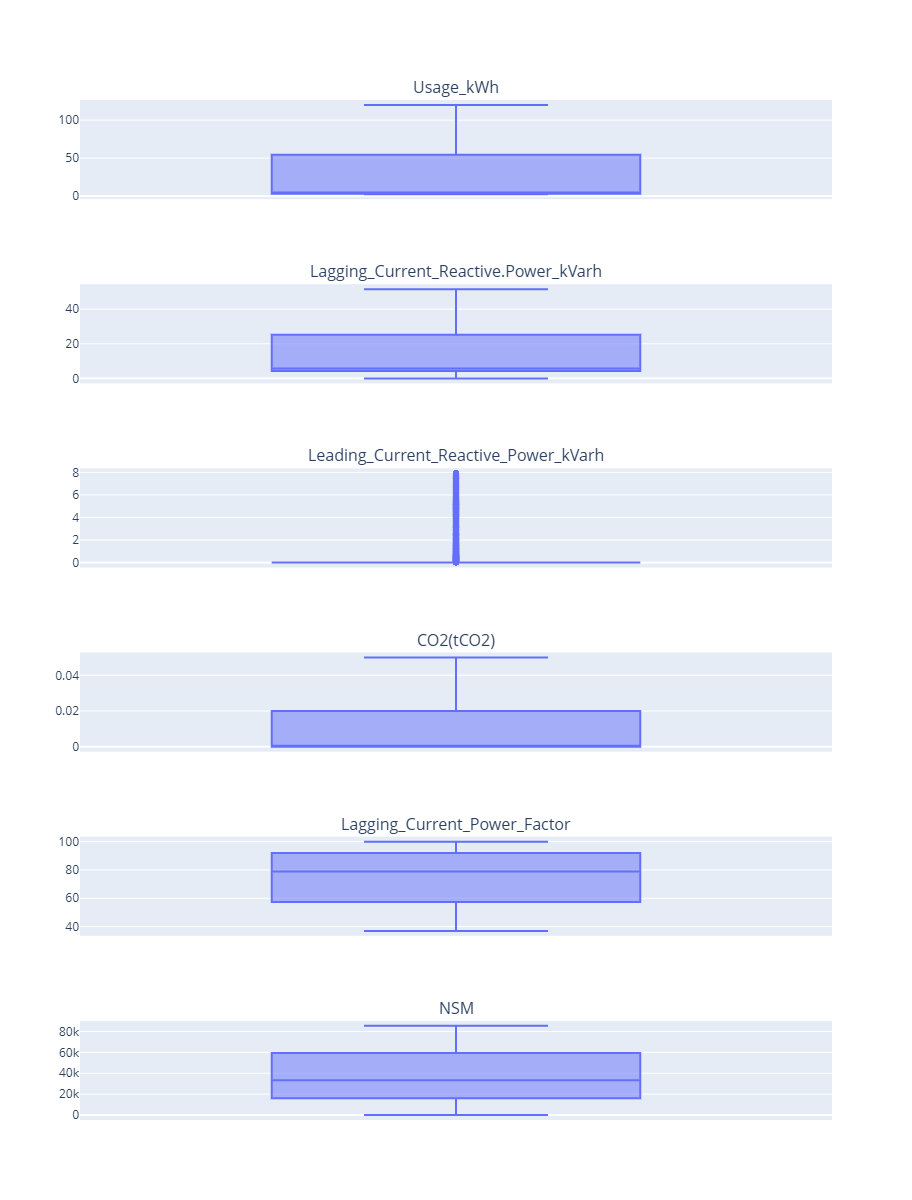

In [103]:
#Detect the outliers 
fig = make_subplots(rows=len(numeric_cols), cols=1, subplot_titles=numeric_cols)

for i, feature in enumerate(numeric_cols):
    boxplot = px.box(df, y=feature, title=f'Boxplot of {feature}')
    # Add boxplot to subplots
    for data in boxplot.data:
        fig.add_trace(data, row=i+1, col=1)

fig.update_layout(height=200*len(numeric_cols), showlegend=False)

fig.show() 

# Data Analysis & Visualizations

In [104]:
df.nunique()

date                                    26323
Usage_kWh                                2759
Lagging_Current_Reactive.Power_kVarh     1433
Leading_Current_Reactive_Power_kVarh      221
CO2(tCO2)                                   6
Lagging_Current_Power_Factor             5035
NSM                                        96
WeekStatus                                  2
Day_of_week                                 7
Load_Type                                   3
dtype: int64

In [105]:
# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y %H:%M')

In [106]:
df

date  Usage_kWh  Lagging_Current_Reactive.Power_kVarh  \
0     2018-01-01 00:15:00       3.17                                  2.95   
1     2018-01-01 00:30:00       4.00                                  4.46   
2     2018-01-01 00:45:00       3.24                                  3.28   
3     2018-01-01 01:00:00       3.31                                  3.56   
4     2018-01-01 01:15:00       3.82                                  4.50   
...                   ...        ...                                   ...   
35035 2018-12-31 23:00:00       3.85                                  4.86   
35036 2018-12-31 23:15:00       3.74                                  3.74   
35037 2018-12-31 23:30:00       3.78                                  3.17   
35038 2018-12-31 23:45:00       3.78                                  3.06   
35039 2018-12-31 00:00:00       3.67                                  3.02   

       Leading_Current_Reactive_Power_kVarh  CO2(tCO2)  \
0                                      0.00        0.0   
1                                      0.00        0.0   
2                                      0.00        0.0   
3                                      0.00        0.0   
4                                      0.00        0.0   
...                                     ...        ...   
35035                                  0.00        0.0   
35036                                  0.00        0.0   
35037                                  0.07        0.0   
35038                                  0.11        0.0   
35039                                  0.07        0.0   

       Lagging_Current_Power_Factor    NSM WeekStatus Day_of_week   Load_Type  
0                             73.21    900    Weekday      Monday  Light_Load  
1                             66.77   1800    Weekday      Monday  Light_Load  
2                             70.28   2700    Weekday      Monday  Light_Load  
3                             68.09   3600    Weekday      Monday  Light_Load  
4                             64.72   4500    Weekday      Monday  Light_Load  
...                             ...    ...        ...         ...         ...  
35035                         62.10  82800    Weekday      Monday  Light_Load  
35036                         70.71  83700    Weekday      Monday  Light_Load  
35037                         76.62  84600    Weekday      Monday  Light_Load  
35038                         77.72  85500    Weekday      Monday  Light_Load  
35039                         77.22      0    Weekday      Monday  Light_Load  

[26323 rows x 10 columns]

In [107]:
 #Summary statistics of the datase
df.describe()

date     Usage_kWh  \
count                          26323  26323.000000   
mean   2018-07-03 16:35:23.580139264     29.345597   
min              2018-01-01 00:00:00      2.450000   
25%              2018-04-04 14:22:30      3.170000   
50%              2018-07-04 10:00:00      4.790000   
75%              2018-10-02 13:22:30     54.450000   
max              2018-12-31 23:45:00    119.950000   
std                              NaN     31.667558   

       Lagging_Current_Reactive.Power_kVarh  \
count                          26323.000000   
mean                              14.218428   
min                                0.000000   
25%                                4.280000   
50%                                5.690000   
75%                               25.160000   
max                               51.550000   
std                               13.982168   

       Leading_Current_Reactive_Power_kVarh     CO2(tCO2)  \
count                          26323.000000  26323.000000   
mean                               0.338376      0.012627   
min                                0.000000      0.000000   
25%                                0.000000      0.000000   
50%                                0.000000      0.000000   
75%                                0.000000      0.020000   
max                                7.920000      0.050000   
std                                1.208583      0.015366   

       Lagging_Current_Power_Factor           NSM  
count                  26323.000000  26323.000000  
mean                      75.120181  37870.022414  
min                       36.940000      0.000000  
25%                       57.330000  16200.000000  
50%                       78.970000  33300.000000  
75%                       91.950000  59400.000000  
max                      100.000000  85500.000000  
std                       18.469280  25408.277088

In [108]:
cf.go_offline()

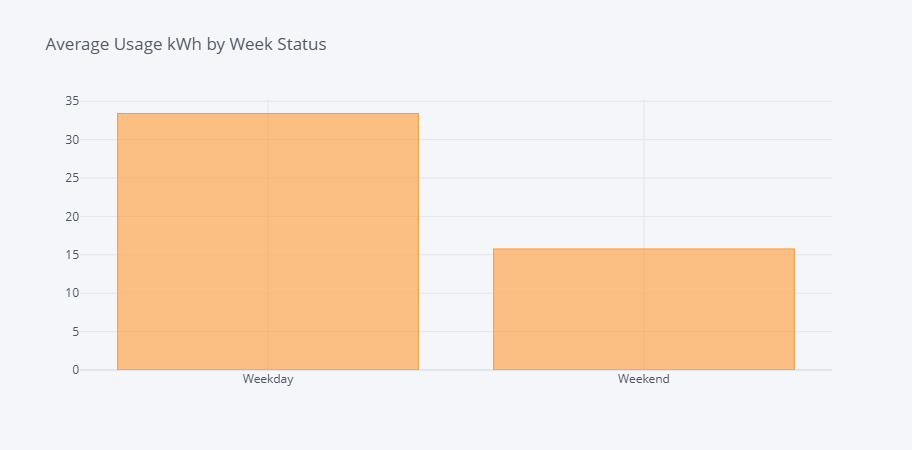

In [109]:
# Bar Plot
df[['WeekStatus', 'Usage_kWh']].groupby('WeekStatus').mean().iplot(kind='bar', title='Average Usage kWh by Week Status')

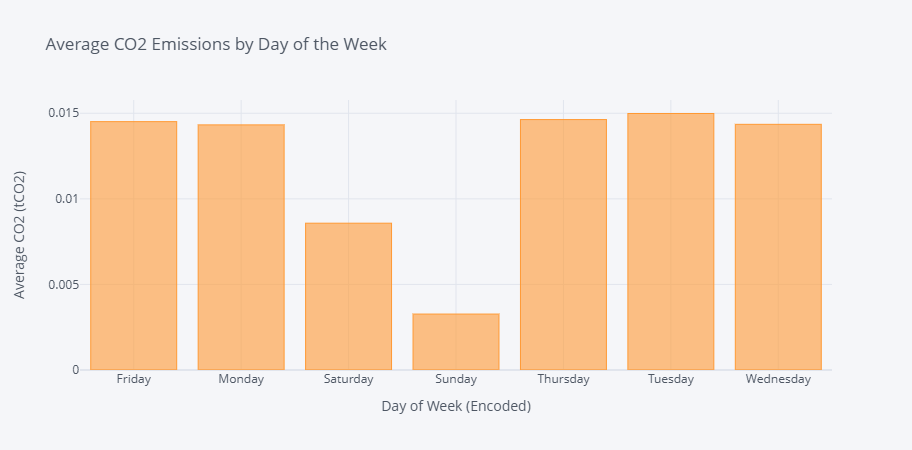

In [110]:
avg_co2_by_day = df.groupby('Day_of_week')['CO2(tCO2)'].mean()
avg_co2_by_day.iplot(kind='bar', title='Average CO2 Emissions by Day of the Week', xTitle='Day of Week (Encoded)', yTitle='Average CO2 (tCO2)')

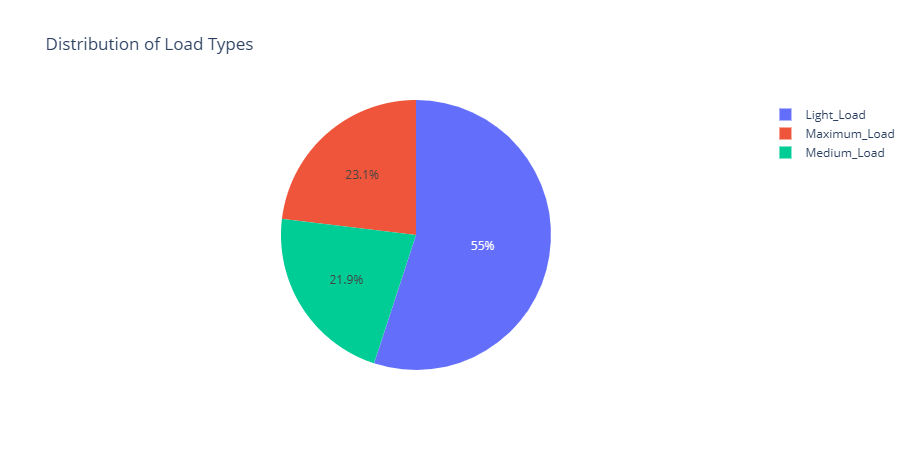

In [111]:
# Count the occurrences of each load type
load_type_counts = df['Load_Type'].value_counts()

# Create the pie chart
fig = go.Figure(data=[go.Pie(labels=load_type_counts.index, values=load_type_counts.values)])
fig.update_layout(title='Distribution of Load Types')
fig.show()

In [112]:
# Identify non-numeric columns
non_numeric_columns = df.select_dtypes(exclude=['float', 'int']).columns

# Drop non-numeric columns
numeric_df = df.drop(columns=non_numeric_columns) 

# Compute correlation matrix
correlation_matrix = numeric_df.corr()  

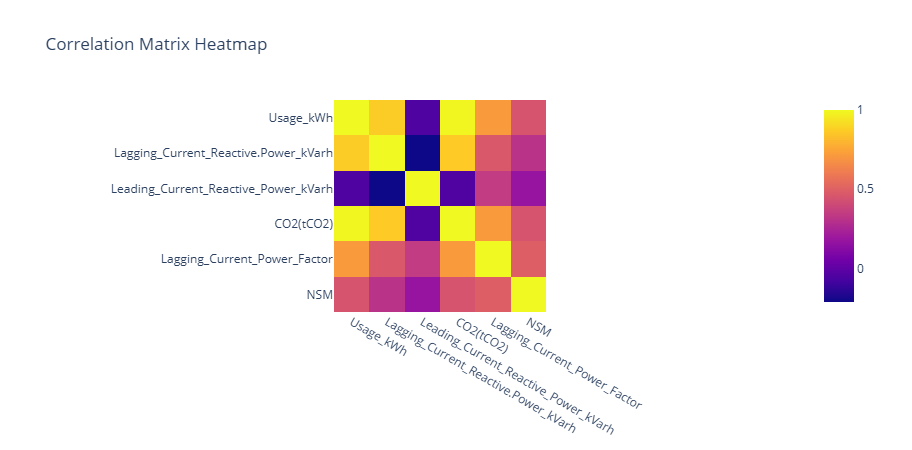

In [113]:
# Create a heatmap
fig = px.imshow(correlation_matrix,
                text_auto=True,
                x=correlation_matrix.columns,
                y=correlation_matrix.columns,
                title="Correlation Matrix Heatmap")
fig.show()

# Data Prepration for Models

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26323 entries, 0 to 35039
Data columns (total 10 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   date                                  26323 non-null  datetime64[ns]
 1   Usage_kWh                             26323 non-null  float64       
 2   Lagging_Current_Reactive.Power_kVarh  26323 non-null  float64       
 3   Leading_Current_Reactive_Power_kVarh  26323 non-null  float64       
 4   CO2(tCO2)                             26323 non-null  float64       
 5   Lagging_Current_Power_Factor          26323 non-null  float64       
 6   NSM                                   26323 non-null  int64         
 7   WeekStatus                            26323 non-null  object        
 8   Day_of_week                           26323 non-null  object        
 9   Load_Type                             26323 non-null  object        
dtypes: 

In [115]:
#count the value for load type 
df["Load_Type"].value_counts()

Load_Type
Light_Load      14487
Maximum_Load     6079
Medium_Load      5757
Name: count, dtype: int64

In [116]:
# Data Transformation:
# Encode Categorical Columns
categ = df.select_dtypes(include = "object").columns

columns_to_convert = ['NSM']
df[columns_to_convert] = df[columns_to_convert].astype(float)

le = LabelEncoder()
df[categ] = df[categ].apply(le.fit_transform)

In [117]:
#count the value for load type after LabelEncoder
df["Load_Type"].value_counts()

Load_Type
0    14487
1     6079
2     5757
Name: count, dtype: int64

By checking the value we can see that

0 = Light Load

2 = Medium Load

1 = Maximum Load

In [118]:
df.head()

date  Usage_kWh  Lagging_Current_Reactive.Power_kVarh  \
0 2018-01-01 00:15:00       3.17                                  2.95   
1 2018-01-01 00:30:00       4.00                                  4.46   
2 2018-01-01 00:45:00       3.24                                  3.28   
3 2018-01-01 01:00:00       3.31                                  3.56   
4 2018-01-01 01:15:00       3.82                                  4.50   

   Leading_Current_Reactive_Power_kVarh  CO2(tCO2)  \
0                                   0.0        0.0   
1                                   0.0        0.0   
2                                   0.0        0.0   
3                                   0.0        0.0   
4                                   0.0        0.0   

   Lagging_Current_Power_Factor     NSM  WeekStatus  Day_of_week  Load_Type  
0                         73.21   900.0           0            1          0  
1                         66.77  1800.0           0            1          0  
2                         70.28  2700.0           0            1          0  
3                         68.09  3600.0           0            1          0  
4                         64.72  4500.0           0            1          0

In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26323 entries, 0 to 35039
Data columns (total 10 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   date                                  26323 non-null  datetime64[ns]
 1   Usage_kWh                             26323 non-null  float64       
 2   Lagging_Current_Reactive.Power_kVarh  26323 non-null  float64       
 3   Leading_Current_Reactive_Power_kVarh  26323 non-null  float64       
 4   CO2(tCO2)                             26323 non-null  float64       
 5   Lagging_Current_Power_Factor          26323 non-null  float64       
 6   NSM                                   26323 non-null  float64       
 7   WeekStatus                            26323 non-null  int64         
 8   Day_of_week                           26323 non-null  int64         
 9   Load_Type                             26323 non-null  int64         
dtypes: 

In [120]:
df = df.drop('date', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26323 entries, 0 to 35039
Data columns (total 9 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Usage_kWh                             26323 non-null  float64
 1   Lagging_Current_Reactive.Power_kVarh  26323 non-null  float64
 2   Leading_Current_Reactive_Power_kVarh  26323 non-null  float64
 3   CO2(tCO2)                             26323 non-null  float64
 4   Lagging_Current_Power_Factor          26323 non-null  float64
 5   NSM                                   26323 non-null  float64
 6   WeekStatus                            26323 non-null  int64  
 7   Day_of_week                           26323 non-null  int64  
 8   Load_Type                             26323 non-null  int64  
dtypes: float64(6), int64(3)
memory usage: 2.0 MB


In [121]:
# Data Augmentation
# Apply random noise
noisy_df = df.apply(lambda x: x + np.random.normal(0, 0.01, len(x)) if x.dtype == 'float' else x)

# Duplicate and shuffle
duplicated_df = pd.concat([df] * 2, ignore_index=True)
shuffled_df = shuffle(duplicated_df)

# Apply SMOTE
X = df.drop('Load_Type', axis=1)
y = df['Load_Type']

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

X_resampled['Load_Type'] = y_resampled
df_aug = X_resampled
df_aug.head()

Usage_kWh  Lagging_Current_Reactive.Power_kVarh  \
0       3.17                                  2.95   
1       4.00                                  4.46   
2       3.24                                  3.28   
3       3.31                                  3.56   
4       3.82                                  4.50   

   Leading_Current_Reactive_Power_kVarh  CO2(tCO2)  \
0                                   0.0        0.0   
1                                   0.0        0.0   
2                                   0.0        0.0   
3                                   0.0        0.0   
4                                   0.0        0.0   

   Lagging_Current_Power_Factor     NSM  WeekStatus  Day_of_week  Load_Type  
0                         73.21   900.0           0            1          0  
1                         66.77  1800.0           0            1          0  
2                         70.28  2700.0           0            1          0  
3                         68.09  3600.0           0            1          0  
4                         64.72  4500.0           0            1          0

In [122]:
df_aug.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43461 entries, 0 to 43460
Data columns (total 9 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Usage_kWh                             43461 non-null  float64
 1   Lagging_Current_Reactive.Power_kVarh  43461 non-null  float64
 2   Leading_Current_Reactive_Power_kVarh  43461 non-null  float64
 3   CO2(tCO2)                             43461 non-null  float64
 4   Lagging_Current_Power_Factor          43461 non-null  float64
 5   NSM                                   43461 non-null  float64
 6   WeekStatus                            43461 non-null  int64  
 7   Day_of_week                           43461 non-null  int64  
 8   Load_Type                             43461 non-null  int64  
dtypes: float64(6), int64(3)
memory usage: 3.0 MB


In [123]:
#count the value for load type after data augmentstion
df_aug["Load_Type"].value_counts()

Load_Type
0    14487
2    14487
1    14487
Name: count, dtype: int64

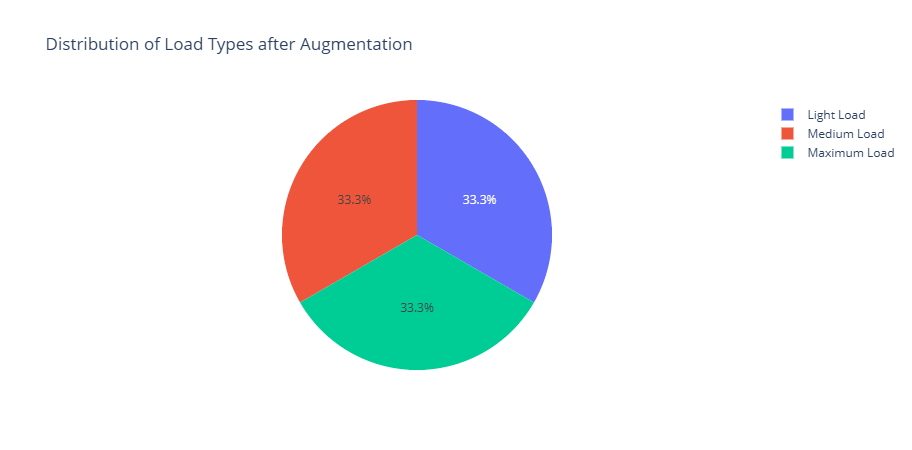

In [124]:
# Count the occurrences of each load type 
load_type_counts = df_aug['Load_Type'].value_counts()

labals_lis = ['Light Load',
              'Medium Load',
              'Maximum Load' ]

# Create the pie chart
fig = go.Figure(data=[go.Pie(labels=labals_lis, values=load_type_counts.values)])
fig.update_layout(title='Distribution of Load Types after Augmentation')
fig.show()

# Classification Models

### Feature Engineering

In [125]:
def feature_selection_using_RF(x,y):
    model = RandomForestClassifier()
    rfe = RFE(model, n_features_to_select=5)  # Choose the number of features to select
    rfe.fit(x, y)

    selected_features = x.columns[rfe.support_]
    importances = np.max(rfe.ranking_) + 1 - rfe.ranking_
    fig = px.bar(x=x.columns, y=importances, labels={'x': 'Feature', 'y': 'Importance'},
                     title='Feature Importances')
    fig.show()
    x = x[selected_features]
    return x,y

In [126]:
x = df.drop(['Load_Type'], axis=1)
y = df.Load_Type

In [127]:
xg = df_aug.drop(['Load_Type'], axis=1)
yg = df_aug.Load_Type

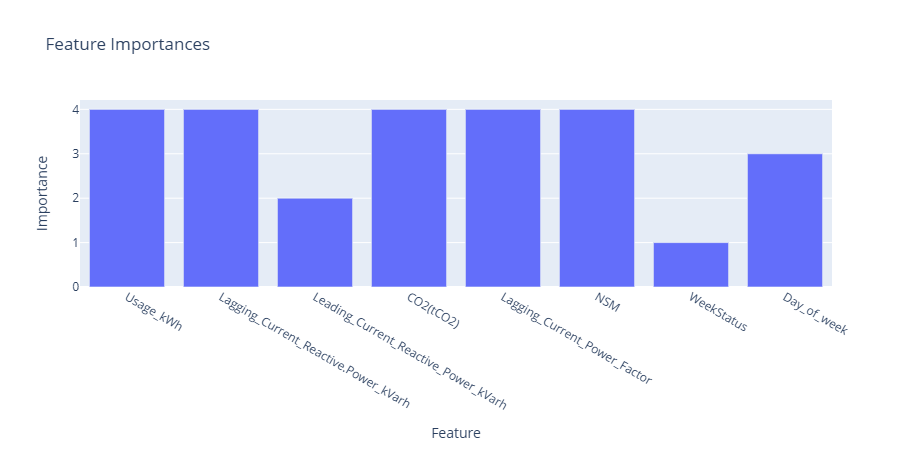

In [128]:
x , y = feature_selection_using_RF(x,y)

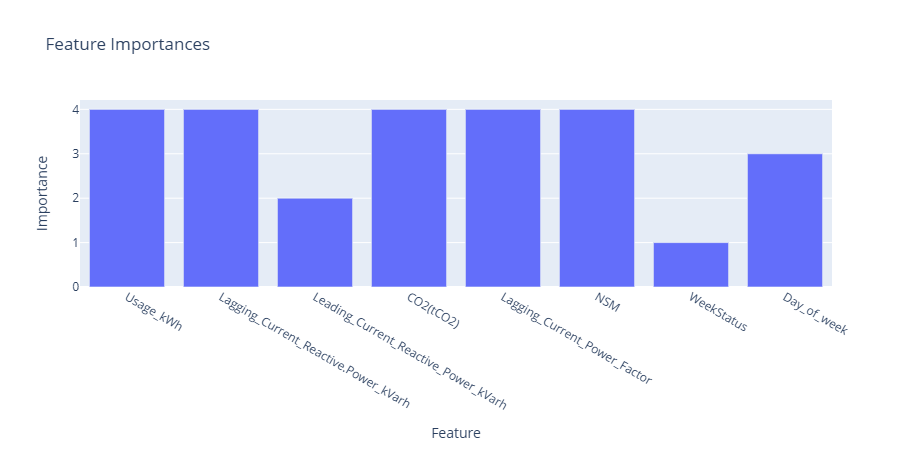

In [129]:
xg , yg = feature_selection_using_RF(xg,yg)

In [130]:
# Split the dataset and prepare some lists to store the models
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state = 42) 
xg_train, xg_test, yg_train, yg_test = train_test_split(xg, yg, test_size=0.25, random_state = 42)

### Model Training

In [131]:
#Loop for the training model  
names = [
    "Logistic Regression",
    "KNN",
    "Decision Tree",
    "Naive Bayes",
    "Random Forest",
    "Random Forest with Extra Trees",
    "AdaBoost",
    "XGBoost"
]
 
clf = [
    LogisticRegression(),
    KNeighborsClassifier(3),
    DecisionTreeClassifier(max_depth=5),
    GaussianNB(),
    RandomForestClassifier(n_estimators=200, max_leaf_nodes=16),
    ExtraTreesClassifier(),
    AdaBoostClassifier(DecisionTreeClassifier(max_depth=3)),
    xgb.XGBClassifier()
]

In [132]:
def train_clf(x_train, y_train,x_test, y_test):
    scores = []
    for model in tqdm(clf):
        model.fit(x_train, y_train)
        score = model.score(x_test, y_test)
        scores.append(score)
#         print(model)
#         print(score)
    return pd.DataFrame(zip(names,scores), columns=['Classifier', 'Accuracy'])

  0%|          | 0/8 [00:00<?, ?it/s]

                       Classifier  Accuracy
7                         XGBoost  0.903966
5  Random Forest with Extra Trees  0.898496
4                   Random Forest  0.892570
1                             KNN  0.890290
2                   Decision Tree  0.884364
6                        AdaBoost  0.882845
3                     Naive Bayes  0.764625
0             Logistic Regression  0.717824


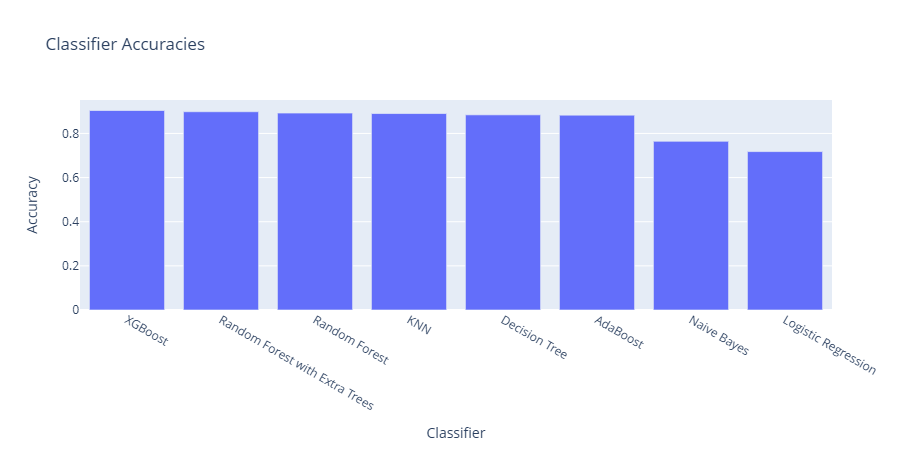

In [133]:
#List the classifier and their accuracy
scores_df = train_clf(x_train, y_train,x_test, y_test)
scores_df = scores_df.sort_values(by=['Accuracy'], ascending=[False])
print(scores_df)

# Plot the accuracies using Plotly Express
fig = px.bar(scores_df, x='Classifier', y='Accuracy', labels={'Classifier': 'Classifier', 'Accuracy': 'Accuracy'},
             title='Classifier Accuracies')
fig.update_layout(xaxis_title='Classifier', yaxis_title='Accuracy')
fig.show()

  0%|          | 0/8 [00:00<?, ?it/s]

                       Classifier  Accuracy
7                         XGBoost  0.903966
5  Random Forest with Extra Trees  0.898496
4                   Random Forest  0.892570
1                             KNN  0.890290
2                   Decision Tree  0.884364
6                        AdaBoost  0.882845
3                     Naive Bayes  0.764625
0             Logistic Regression  0.717824


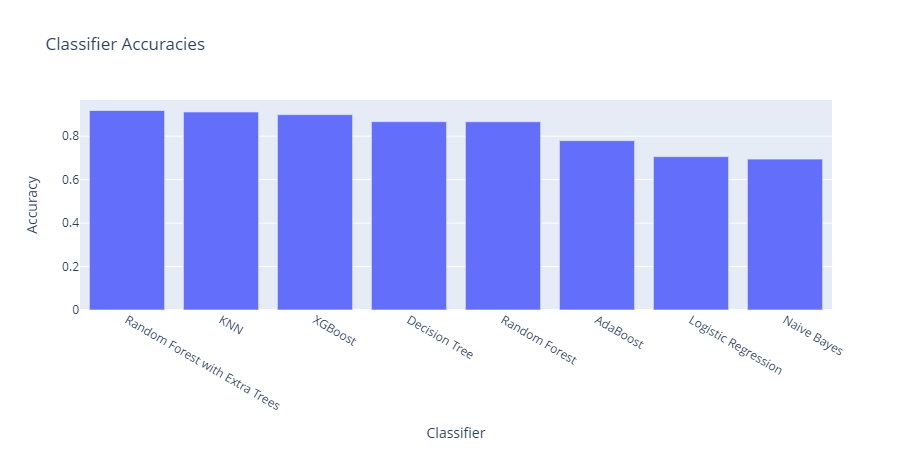

In [134]:
#List the classifier and their accuracy
scores_df_aug = train_clf(xg_train, yg_train,xg_test, yg_test)
scores_df_aug = scores_df_aug.sort_values(by=['Accuracy'], ascending=[False])
print(scores_df)

# Plot the accuracies using Plotly Express
fig = px.bar(scores_df_aug, x='Classifier', y='Accuracy', labels={'Classifier': 'Classifier', 'Accuracy': 'Accuracy'},
             title='Classifier Accuracies')
fig.update_layout(xaxis_title='Classifier', yaxis_title='Accuracy')
fig.show()

In [135]:
#Naive grid search implementation
parameters = {'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]}
CBC = xgb.XGBClassifier()
Grid_CBC = GridSearchCV(estimator=CBC, param_grid = parameters, cv = 2, n_jobs=-1)
Grid_CBC.fit(xg_train, yg_train)

GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': range(2, 10),
                         'n_estimators': range(60, 220, 40)})

In [136]:
print("Results from Grid Search" )
print("\n The best estimator across ALL searched params:\n",Grid_CBC.best_estimator_)
print("\n The best score across ALL searched params:\n",Grid_CBC.best_score_)
print("\n The best parameters across ALL searched params:\n",Grid_CBC.best_params_)

Results from Grid Search

 The best estimator across ALL searched params:
 XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=180, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

 The best score across ALL searched params:
 0.8904740065064031

 The best parameters across ALL searched params:
 {'learning_rate': 0.1, 'max_depth': 9, 'n_estim

In [137]:
#This is the classification model with the best parameters
Grid_CBC

GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': range(2, 10),
                         'n_estimators': range(60, 220, 40)})

In [138]:
# Make predictions on the test set
yg_pred = Grid_CBC.predict(xg_test)

### Model Evaluation

In [139]:
# Calculate evaluation metrics
def cls_report(y_test, y_pred):
    y_test_binarized = label_binarize(y_test, classes=[0, 1, 2]) 
    n_classes = y_test_binarized.shape[1]
    y_pred_reshaped = y_pred.reshape(-1, 1)
    class_report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    roc_auc = roc_auc_score(y_test_binarized, y_pred_reshaped)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return class_report, conf_matrix, roc_auc, mse, r2

In [140]:
class_report, conf_matrix, roc_auc, mse, r2 = cls_report(yg_test, yg_pred)

AUC-ROC: 0.0106
Mean Squared Error: 0.11080434382477453
R-squared: 0.8346947684269841

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3679
           1       0.86      0.87      0.87      3582
           2       0.86      0.85      0.86      3605

    accuracy                           0.90     10866
   macro avg       0.90      0.90      0.90     10866
weighted avg       0.91      0.90      0.91     10866

Confusion Matrix:
[[3627    8   44]
 [   2 3130  450]
 [  13  516 3076]]


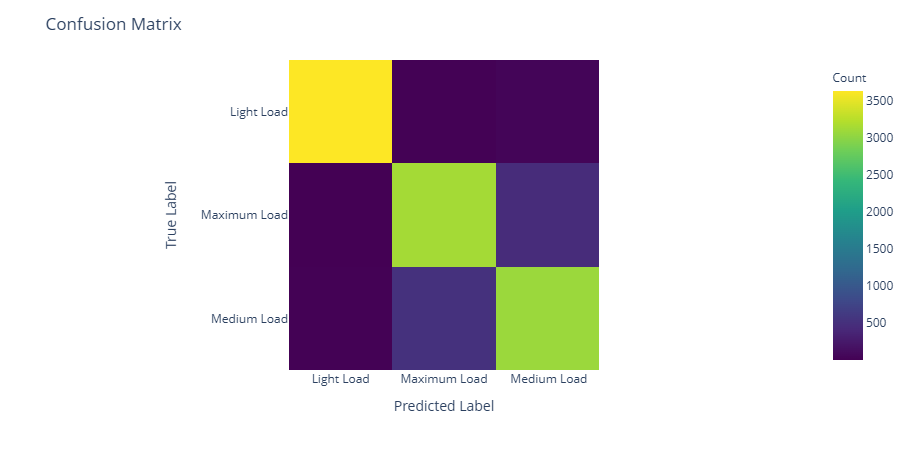

In [141]:
# Print the results
print(f"AUC-ROC: {roc_auc:.4f}")
print('Mean Squared Error:', mse)
print('R-squared:', r2)
print("\nClassification Report:")
print(class_report)
print("Confusion Matrix:")
print(conf_matrix)

# Create a DataFrame for the confusion matrix
classes = ['Light Load','Maximum Load' ,  ' Medium Load']
df_cm = pd.DataFrame(conf_matrix, index=classes, columns=classes)

# Plot the confusion matrix heatmap using Plotly Express
fig = px.imshow(df_cm,
                labels=dict(x="Predicted Label", y="True Label", color="Count"),
                x=classes,
                y=classes,
                color_continuous_scale='Viridis')

# Customize the layout
fig.update_layout(title='Confusion Matrix',
                  xaxis_title='Predicted Label',
                  yaxis_title='True Label')

# Show the plot
fig.show()

# Regression Models

### Feature Engineering

In [142]:
def feature_selection_using_RFR(x,y):
    model = RandomForestRegressor()
    rfe = RFE(model, n_features_to_select=5)  # Choose the number of features to select
    rfe.fit(x, y)

    selected_features = x.columns[rfe.support_]
    importances = np.max(rfe.ranking_) + 1 - rfe.ranking_
    fig = px.bar(x=x.columns, y=importances, labels={'x': 'Feature', 'y': 'Importance'},
                     title='Feature Importances')
    fig.show()
    x = x[selected_features]
    return x,y

In [143]:
# Split the dataset and prepare some lists to store the models
x = df.drop(['Usage_kWh'], axis=1)
y = df.Usage_kWh

In [144]:
# Split the dataset and prepare some lists to store the models
xg = df_aug.drop(['Usage_kWh'], axis=1)
yg = df_aug.Usage_kWh

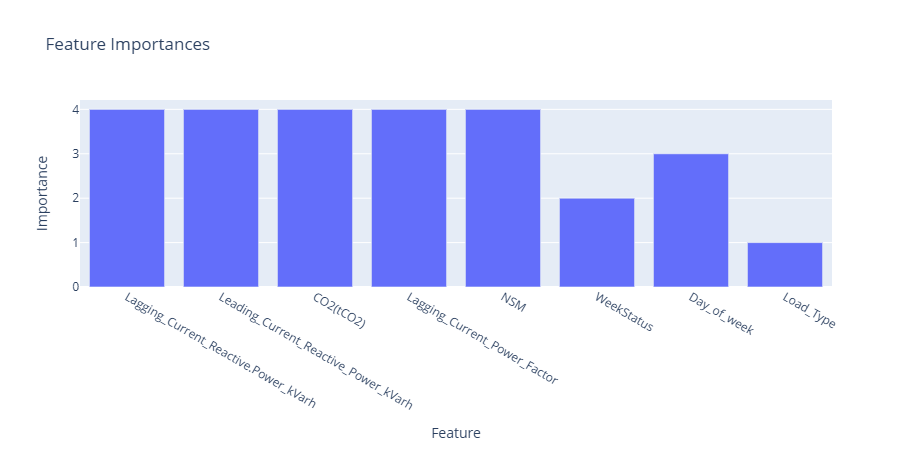

In [145]:
x , y = feature_selection_using_RFR(x,y)

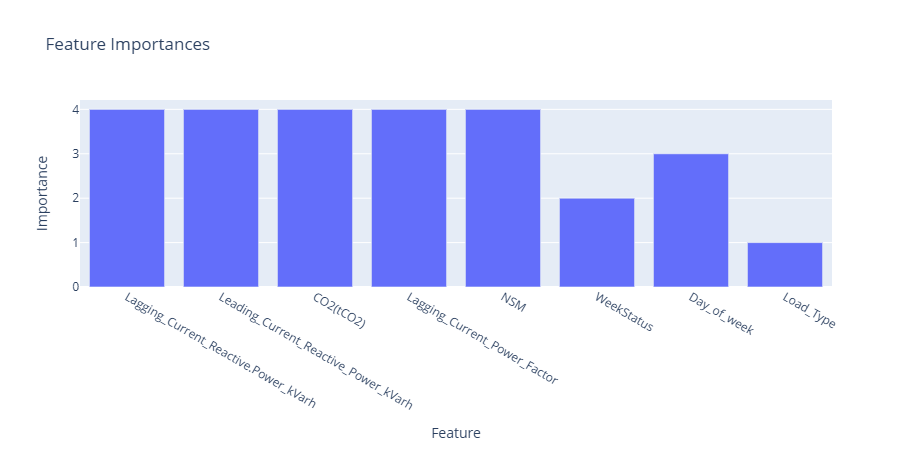

In [146]:
xg , yg = feature_selection_using_RFR(xg,yg)

In [147]:
# Split the dataset and prepare some lists to store the models
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state = 42) 
xg_train, xg_test, yg_train, yg_test = train_test_split(xg, yg, test_size=0.25, random_state = 42) 

### Model Trainging

In [148]:
#Loop for the training model  
names = [
    "Linear Regression",
    "Ridge Regression",
    "Decision Tree Regression",
    "Random Forest Regression",
    "Gradient Boosting Regression",
    "KNN Regression",
    "Bayesian Ridge Regression",
    "XGBoost Regression"
]
 
reg = [
    LinearRegression(),
    Ridge(alpha=0.5),
    DecisionTreeRegressor(max_depth=5),
    RandomForestRegressor(n_estimators=5,max_depth=5),
    GradientBoostingRegressor(),
    KNeighborsRegressor(n_neighbors=35,leaf_size=50),
    BayesianRidge(),
    xgb.XGBRegressor()
]

In [149]:
def train_reg(x_train, y_train,x_test, y_test):
    scores = []
    for model in tqdm(reg):
        model.fit(x_train, y_train)
        score = model.score(x_test, y_test)
        scores.append(score)
#         print(model)
#         print(score)
    return pd.DataFrame(zip(names,scores), columns=['Regressor', 'Accuracy'])

  0%|          | 0/8 [00:00<?, ?it/s]

                      Regressor  Accuracy
7            XGBoost Regression  0.999115
4  Gradient Boosting Regression  0.992847
3      Random Forest Regression  0.987988
2      Decision Tree Regression  0.987270
0             Linear Regression  0.983489
6     Bayesian Ridge Regression  0.983489
1              Ridge Regression  0.962458
5                KNN Regression  0.921074


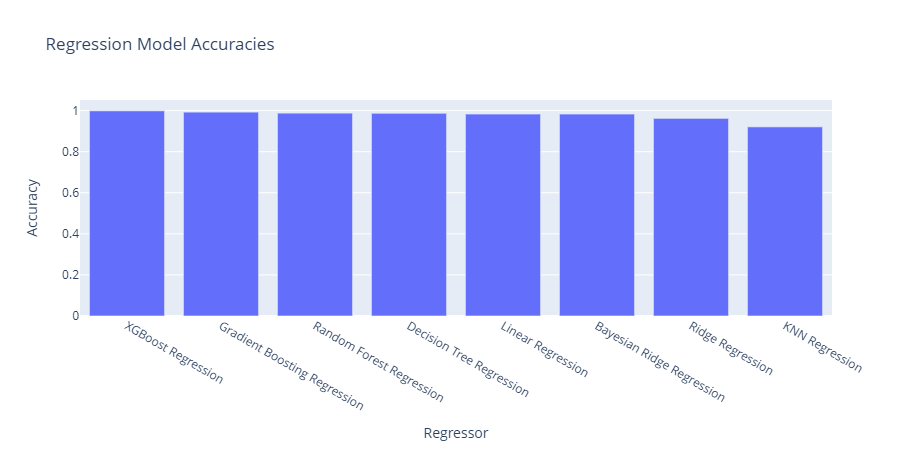

In [150]:
#List the Regressor and their accuracy
scores_df = train_reg(x_train, y_train,x_test, y_test)
scores_df = scores_df.sort_values(by=['Accuracy'], ascending=[False])
print(scores_df)

# Plot the accuracies using Plotly Express
fig = px.bar(scores_df, x='Regressor', y='Accuracy', labels={'Regressor': 'Regressor', 'Accuracy': 'Accuracy'},
             title='Regression Model Accuracies')
fig.update_layout(xaxis_title='Regressor', yaxis_title='Accuracy')
fig.show()

  0%|          | 0/8 [00:00<?, ?it/s]

                      Regressor  Accuracy
7            XGBoost Regression  0.999116
4  Gradient Boosting Regression  0.991640
3      Random Forest Regression  0.984228
2      Decision Tree Regression  0.983962
0             Linear Regression  0.980424
6     Bayesian Ridge Regression  0.980424
1              Ridge Regression  0.970190
5                KNN Regression  0.956642


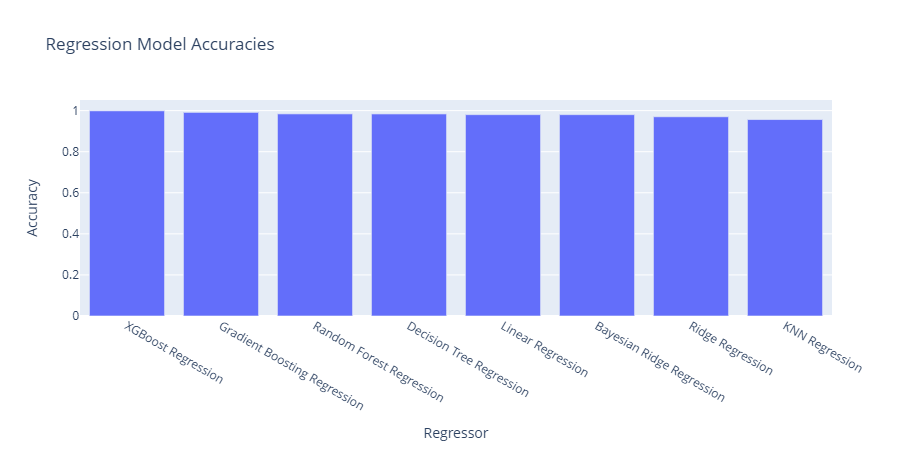

In [151]:
#List the Regressor and their accuracy
scores_df_aug = train_reg(xg_train, yg_train,xg_test, yg_test)
scores_df_aug = scores_df_aug.sort_values(by=['Accuracy'], ascending=[False])
print(scores_df_aug)

# Plot the accuracies using Plotly Express
fig = px.bar(scores_df_aug, x='Regressor', y='Accuracy', labels={'Regressor': 'Regressor', 'Accuracy': 'Accuracy'},
             title='Regression Model Accuracies')
fig.update_layout(xaxis_title='Regressor', yaxis_title='Accuracy')
fig.show()

In [152]:
#Naive grid search implementation
parameters = {'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]}
CBC = xgb.XGBRegressor()
Grid_CBC = GridSearchCV(estimator=CBC, param_grid = parameters, cv = 2, n_jobs=-1)
Grid_CBC.fit(xg_train, yg_train)

GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': range(2, 10),
                         'n_estimators': range(60, 220, 40)})

In [153]:
print("Results from Grid Search" )
print("\n The best estimator across ALL searched params:\n",Grid_CBC.best_estimator_)
print("\n The best score across ALL searched params:\n",Grid_CBC.best_score_)
print("\n The best parameters across ALL searched params:\n",Grid_CBC.best_params_)

Results from Grid Search

 The best estimator across ALL searched params:
 XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=180, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

 The best score across ALL searched params:
 0.9989915497968378

 The best parameters across ALL searched params:
 {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 180}


In [154]:
#This is the classification model with the best parameters
Grid_CBC

GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': range(2, 10),
                         'n_estimators': range(60, 220, 40)})

In [155]:
# Make predictions on the test set
yg_pred = Grid_CBC.predict(xg_test)

### Model Evaluation

In [156]:
def regression_report(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    evs = explained_variance_score(y_true, y_pred)
    
    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Squared Error (RMSE):", rmse)
    print("Mean Absolute Error (MAE):", mae)
    print("R-squared (R2) Score:", r2)
    print("Explained Variance Score:", evs)

In [157]:
regression_report(yg_test, yg_pred)

Mean Squared Error (MSE): 0.7336724567558215
Root Mean Squared Error (RMSE): 0.8565468211112697
Mean Absolute Error (MAE): 0.41149638940786853
R-squared (R2) Score: 0.9992953119156062
Explained Variance Score: 0.9992953904412282


# Clustring Models

In [158]:
encoder = OrdinalEncoder()
df_cluster = df.copy()
df_cluster = df_cluster.drop(['Load_Type'], axis=1)
## Scale Tenure and Monthly Charges
scaler = StandardScaler()
df_cluster[numeric_cols] = scaler.fit_transform(df_cluster[numeric_cols])

#Selecting all variables except tenure and Monthly Charges
df_cluster[df_cluster.columns[~df_cluster.columns.isin(numeric_cols)]] = encoder.fit_transform(df_cluster[df_cluster.columns[~df_cluster.columns.isin(numeric_cols)]])

In [159]:
def optimise_k_means(data, max_k):
    means = []
    inertias = []

    for k in range(1,max_k):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        means.append(k)
        inertias.append(kmeans.inertia_)

    fig = plt.subplots(figsize=(10, 7))
    plt.plot(means, inertias, 'o-', color = 'Blue')
    plt.xlabel("Number of Clusters")
    plt.ylabel("Inertia")
    plt.grid(True)
    plt.show()

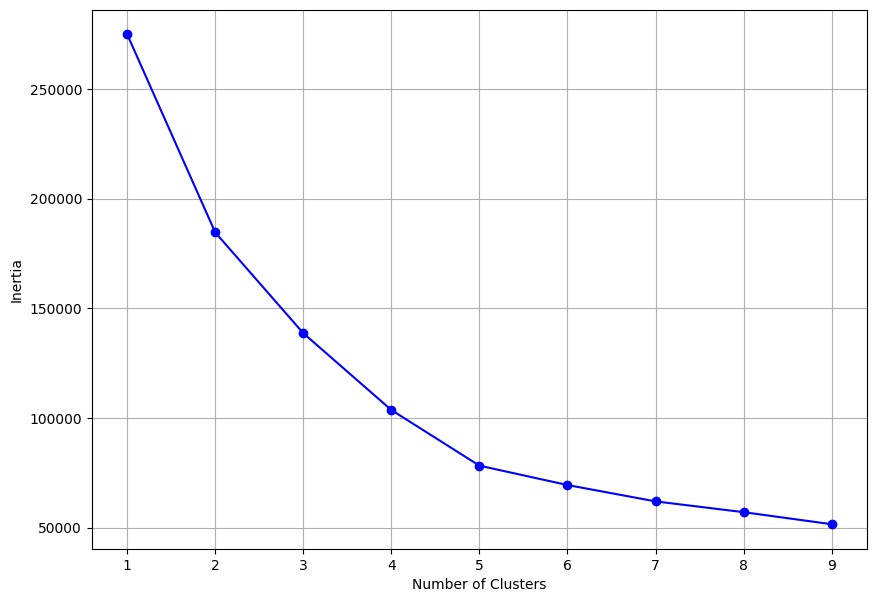

In [160]:
optimise_k_means(df_cluster, 10)

In [164]:
kmeans = KMeans(n_clusters = 4,  random_state=10)
kmeans.fit(df_cluster)
# Save cluster group as a column value in our data_frame
df_cluster['Cluster'] = kmeans.labels_ 

In [165]:
df['Cluster'] = df_cluster['Cluster']

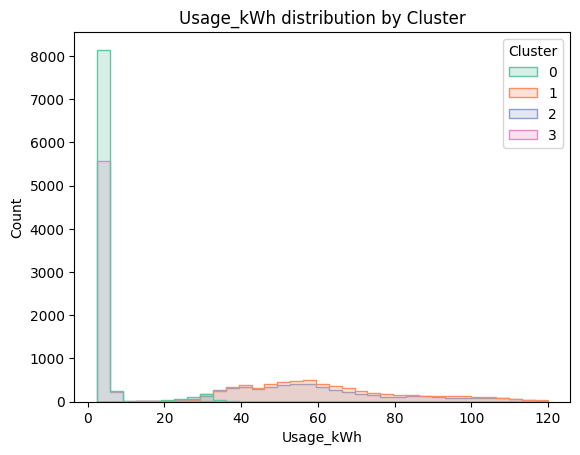

In [166]:
sns.histplot(data=df, x="Usage_kWh", hue="Cluster", element="step", palette="Set2")
plt.title('Usage_kWh distribution by Cluster') 
plt.show()

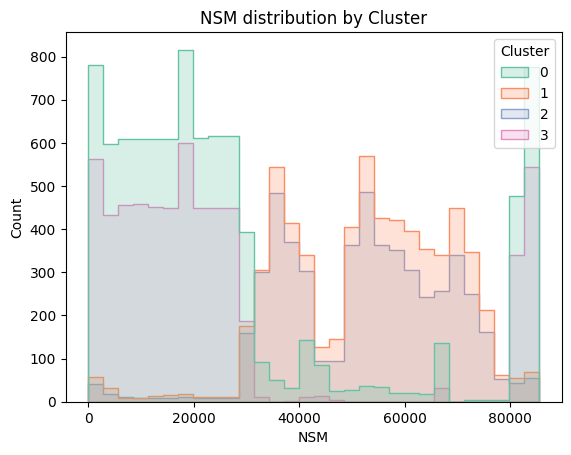

In [167]:
sns.histplot(data=df, x="NSM", hue="Cluster", element="step", palette="Set2")
plt.title('NSM distribution by Cluster') 
plt.show()

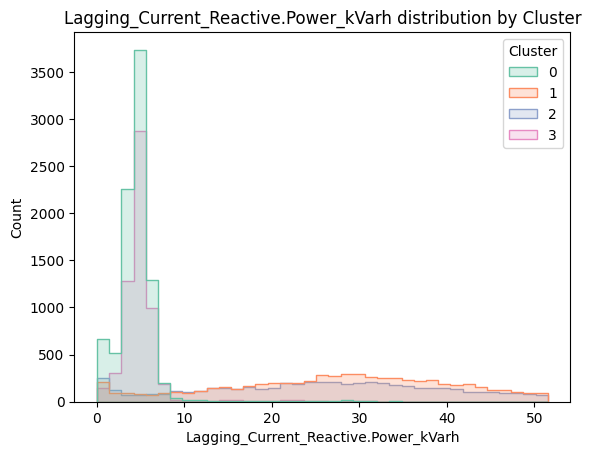

In [168]:
sns.histplot(data=df, x="Lagging_Current_Reactive.Power_kVarh", hue="Cluster", element="step", palette="Set2")
plt.title('Lagging_Current_Reactive.Power_kVarh distribution by Cluster') 
plt.show()

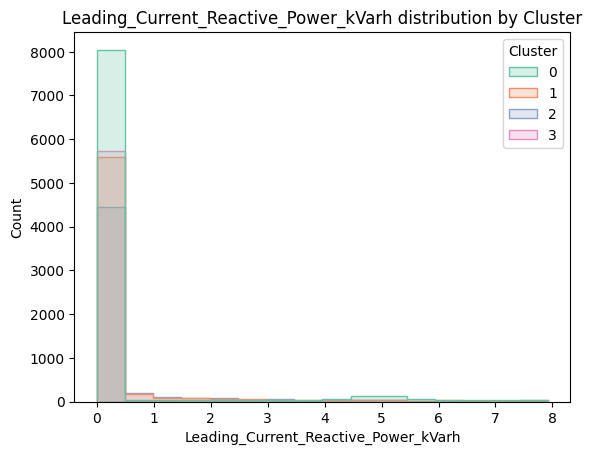

In [169]:
sns.histplot(data=df, x="Leading_Current_Reactive_Power_kVarh", hue="Cluster", element="step", palette="Set2")
plt.title('Leading_Current_Reactive_Power_kVarh distribution by Cluster') 
plt.show()

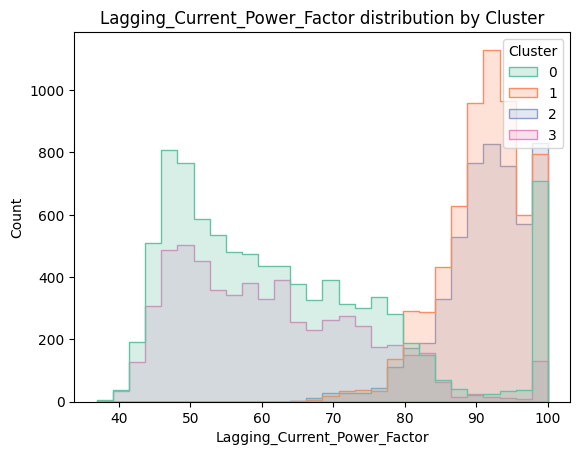

In [170]:
sns.histplot(data=df, x="Lagging_Current_Power_Factor", hue="Cluster", element="step", palette="Set2")
plt.title('Lagging_Current_Power_Factor distribution by Cluster') 
plt.show()

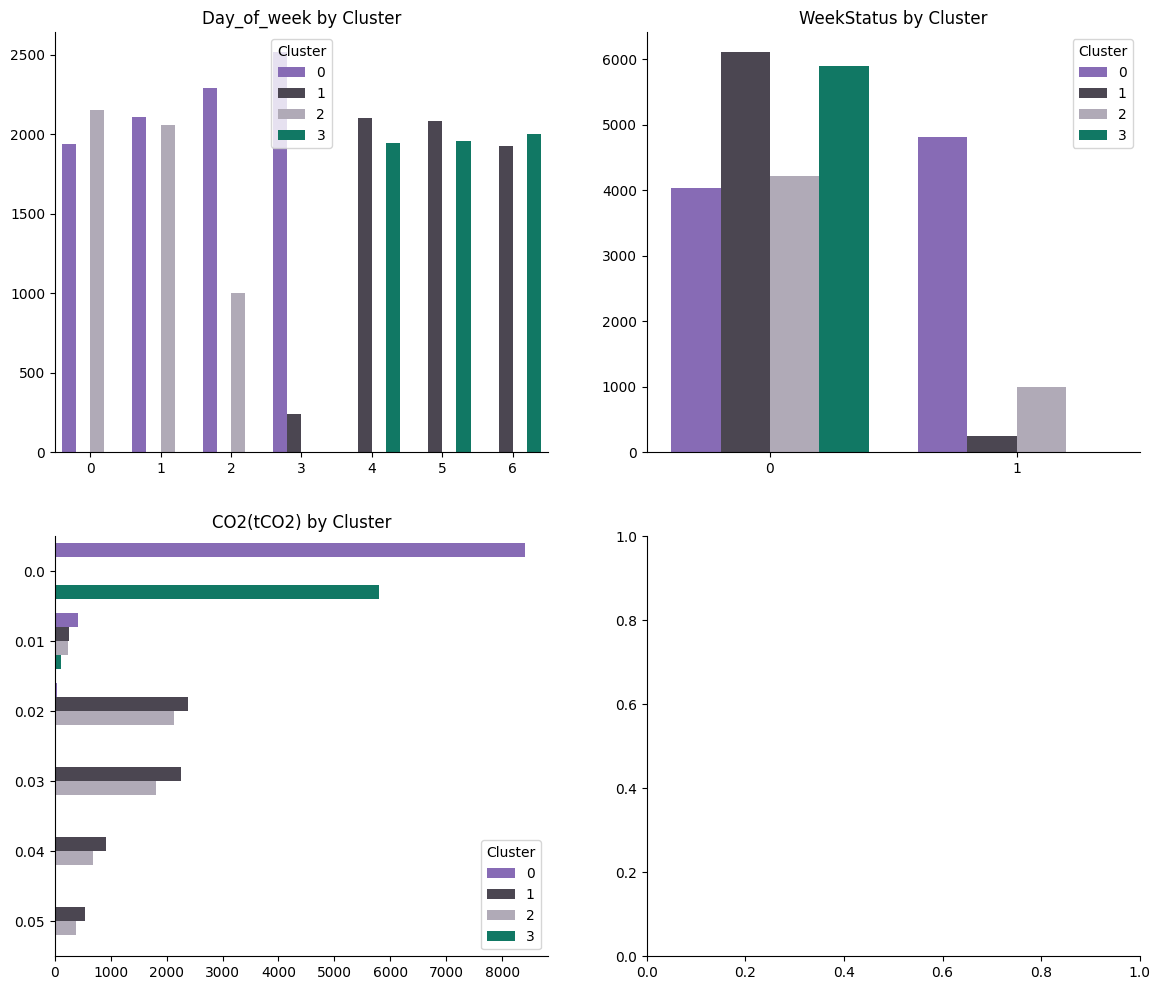

In [171]:
# Gray for No Churn, highlight Churn!
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,12))
sns.despine()
colors = ["#845EC2", "#4B4453", "#B0A8B9","#00896F"]
# Set custom color palette
sns.set_palette(sns.color_palette(colors))
ax = sns.countplot(x="Day_of_week", hue="Cluster", data=df, ax = axes[0,0]).set(title='Day_of_week by Cluster', xlabel=None, ylabel = None)
ax = sns.countplot(x="WeekStatus", hue="Cluster", data=df, ax = axes[0,1]).set(title='WeekStatus by Cluster', xlabel=None, ylabel = None)
ax = sns.countplot(y='CO2(tCO2)', hue="Cluster", data=df, ax = axes[1,0]).set(title='CO2(tCO2) by Cluster', xlabel=None, ylabel = None)
sns.despine() 